# 1. Exploratory analysis (EDA), standarization, normalization, outliers and encoding

In [41]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Estandarización
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from scipy import stats

# Encoding
# ==============================================================================
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
plt.rcParams["figure.figsize"] = (10,8)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Guardar modelo
# ==============================================================================
import pickle

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [42]:
# reads csv
df_train = pd.read_csv('../data/train.csv', index_col=0)
df_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


### Features
- id: only for test & sample submission files, id for prediction sample identification
- price: price in USD
- carat: weight of the diamond
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour
- clarity: a measurement of how clear the diamond is
- x: length in mm
- y: width in mm
- z: depth in mm
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

### Info:
- 1 carat = 200mg

In [43]:
df_density = df_train.copy()
df_density['weight'] = df_density.carat * 200 # mg
df_density['volume'] = df_density.x * df_density.y * df_density.z # mm3
df_density['volume'] = df_density['volume'] / 3 # aprox for a diamond
df_density['density'] = df_density['weight']/df_density['volume'] #mg/mm3
df_density['density'] = df_density['density'] * 1000 #kg/m3
df_density.head()

,carat,cut,color,clarity,depth,table,x,y,z,price,weight,volume,density
id,,,,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353,60.0,16.479141,3640.966406
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183,202.0,55.850576,3616.793496
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983,144.0,38.674972,3723.338184
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371,216.0,58.380400,3699.871875
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588,72.0,19.246500,3740.939911


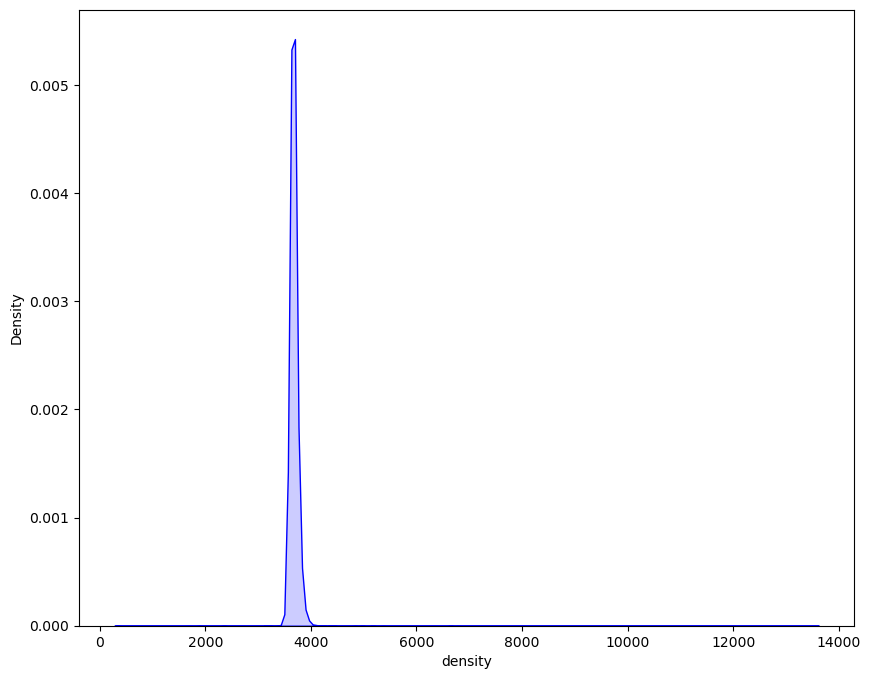

In [44]:
sns.kdeplot(
    df_density.density, 
    color='blue',
    fill=True,
    alpha=.2);

<Axes: xlabel='density'>

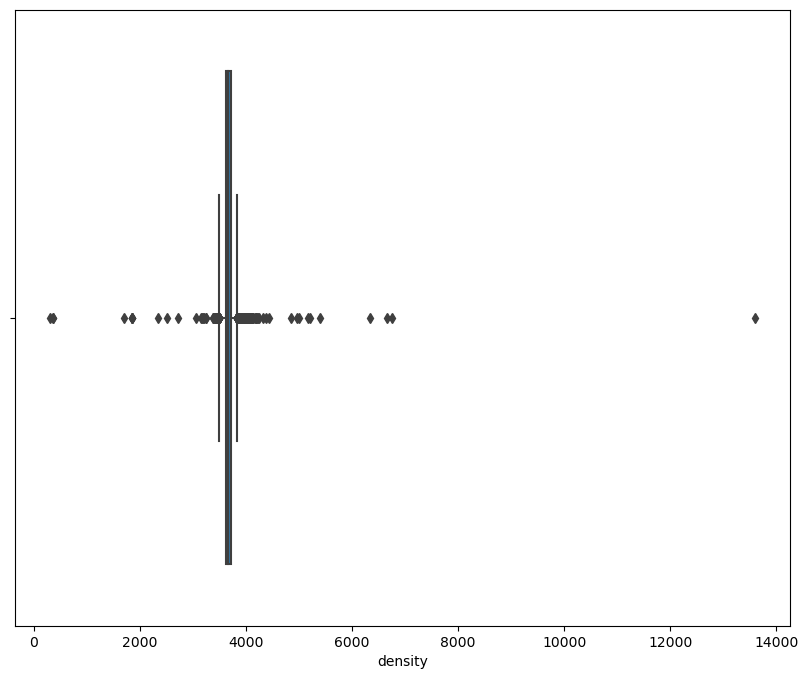

In [45]:
sns.boxplot(
        data=df_density,
        x=df_density.density)

In [46]:
# mean density of a diamond = 3500
# threshold = 5 %

threshold = 0.05

df_density = df_density[(df_density.density > 3500-3500*threshold) & (df_density.density < 3500+3500*threshold)]
df_density.drop(['weight', 'volume', 'density'], axis=1, inplace=True)
df_density

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
5,0.53,Ideal,F,VS1,61.4,57.0,5.18,5.20,3.19,7.496
7,0.33,Ideal,E,VVS2,60.0,56.0,4.53,4.56,2.72,6.877
...,...,...,...,...,...,...,...,...,...,...
40449,0.41,Ideal,E,VS2,61.6,55.0,4.79,4.75,2.94,6.907
40450,0.42,Premium,D,SI2,62.1,59.0,4.78,4.82,2.98,6.551
40451,0.53,Premium,G,VS2,62.0,58.0,5.21,5.18,3.22,7.382


# Exploratory analysis (EDA)

In [47]:
df_train = df_density

In [48]:
df_train.shape

(29508, 10)

In [49]:
df_train.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'price'],
      dtype='object')

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29508 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    29508 non-null  float64
 1   cut      29508 non-null  object 
 2   color    29508 non-null  object 
 3   clarity  29508 non-null  object 
 4   depth    29508 non-null  float64
 5   table    29508 non-null  float64
 6   x        29508 non-null  float64
 7   y        29508 non-null  float64
 8   z        29508 non-null  float64
 9   price    29508 non-null  float64
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


In [51]:
df_train.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [52]:
# df_train[df_train.duplicated() == True].value_counts().sum()
df_train.duplicated().sum()

48

In [53]:
df_train.drop_duplicates(inplace=True)

In [54]:
df_train.duplicated().sum()

0

In [55]:
df_train.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
carat,29460.0,0.731721,0.451884,0.200,0.36,0.560,1.020,3.400
depth,29460.0,61.468615,1.263896,44.000,60.90,61.600,62.200,69.100
table,29460.0,57.008293,2.094105,44.000,56.00,57.000,58.000,95.000
x,29460.0,5.588595,1.110327,3.740,4.58,5.320,6.500,9.490
y,29460.0,5.594834,1.103509,3.710,4.59,5.330,6.500,9.420
z,29460.0,3.435018,0.672055,2.290,2.82,3.270,3.990,6.270
price,29460.0,7.657911,1.013697,5.787,6.76,7.543,8.486,9.842


In [56]:
df_train.describe(include='object').T

,count,unique,top,freq
cut,29460,5,Ideal,14854
color,29460,7,G,6241
clarity,29460,8,VS2,6809


## Variables:
- Response: 
    - Numeric: price
- Predict:
    - Numeric: carat, depth, table, x, y, z
    - Categoric: cut, color, clarity

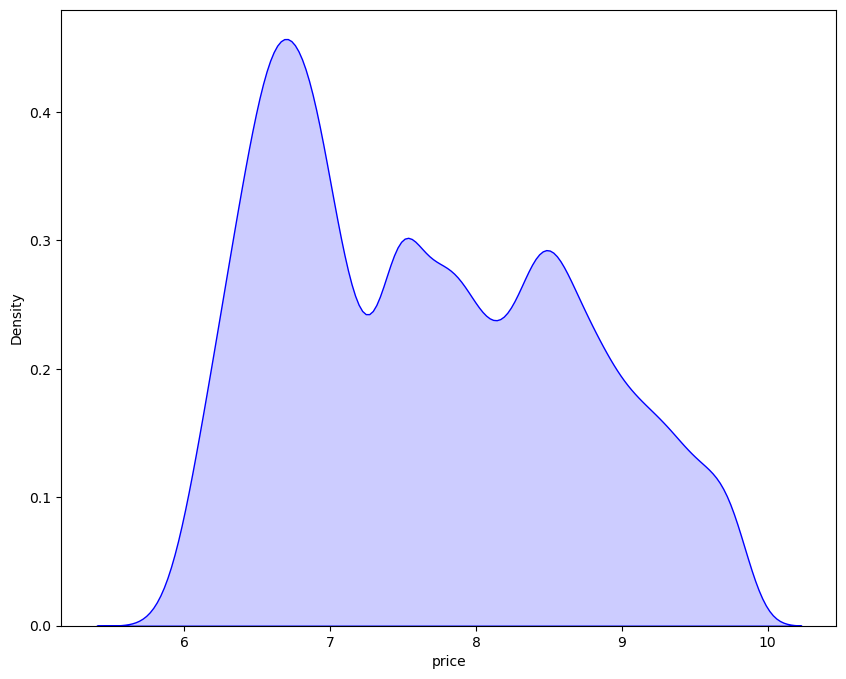

In [57]:
# vamos a ver visualmente como está distribuida la variable respuesta

sns.kdeplot(
    df_train.price, 
    color='blue',
    fill=True,
    alpha=.2);

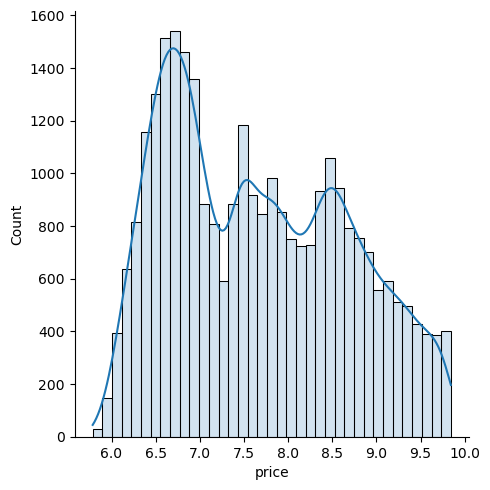

In [58]:
sns.displot(data = df_train,
             x = 'price',
             kde = True,
             alpha=.2);

In [59]:
stats.shapiro(df_train['price'])
# se observa que la variable respuesta posee un p-value de 0.0, por lo que no sigue una distribución normal
# es necesario aplicar métodos de normalización

ShapiroResult(statistic=0.9549190402030945, pvalue=0.0)

## Prediction variables:

#### Numeric:

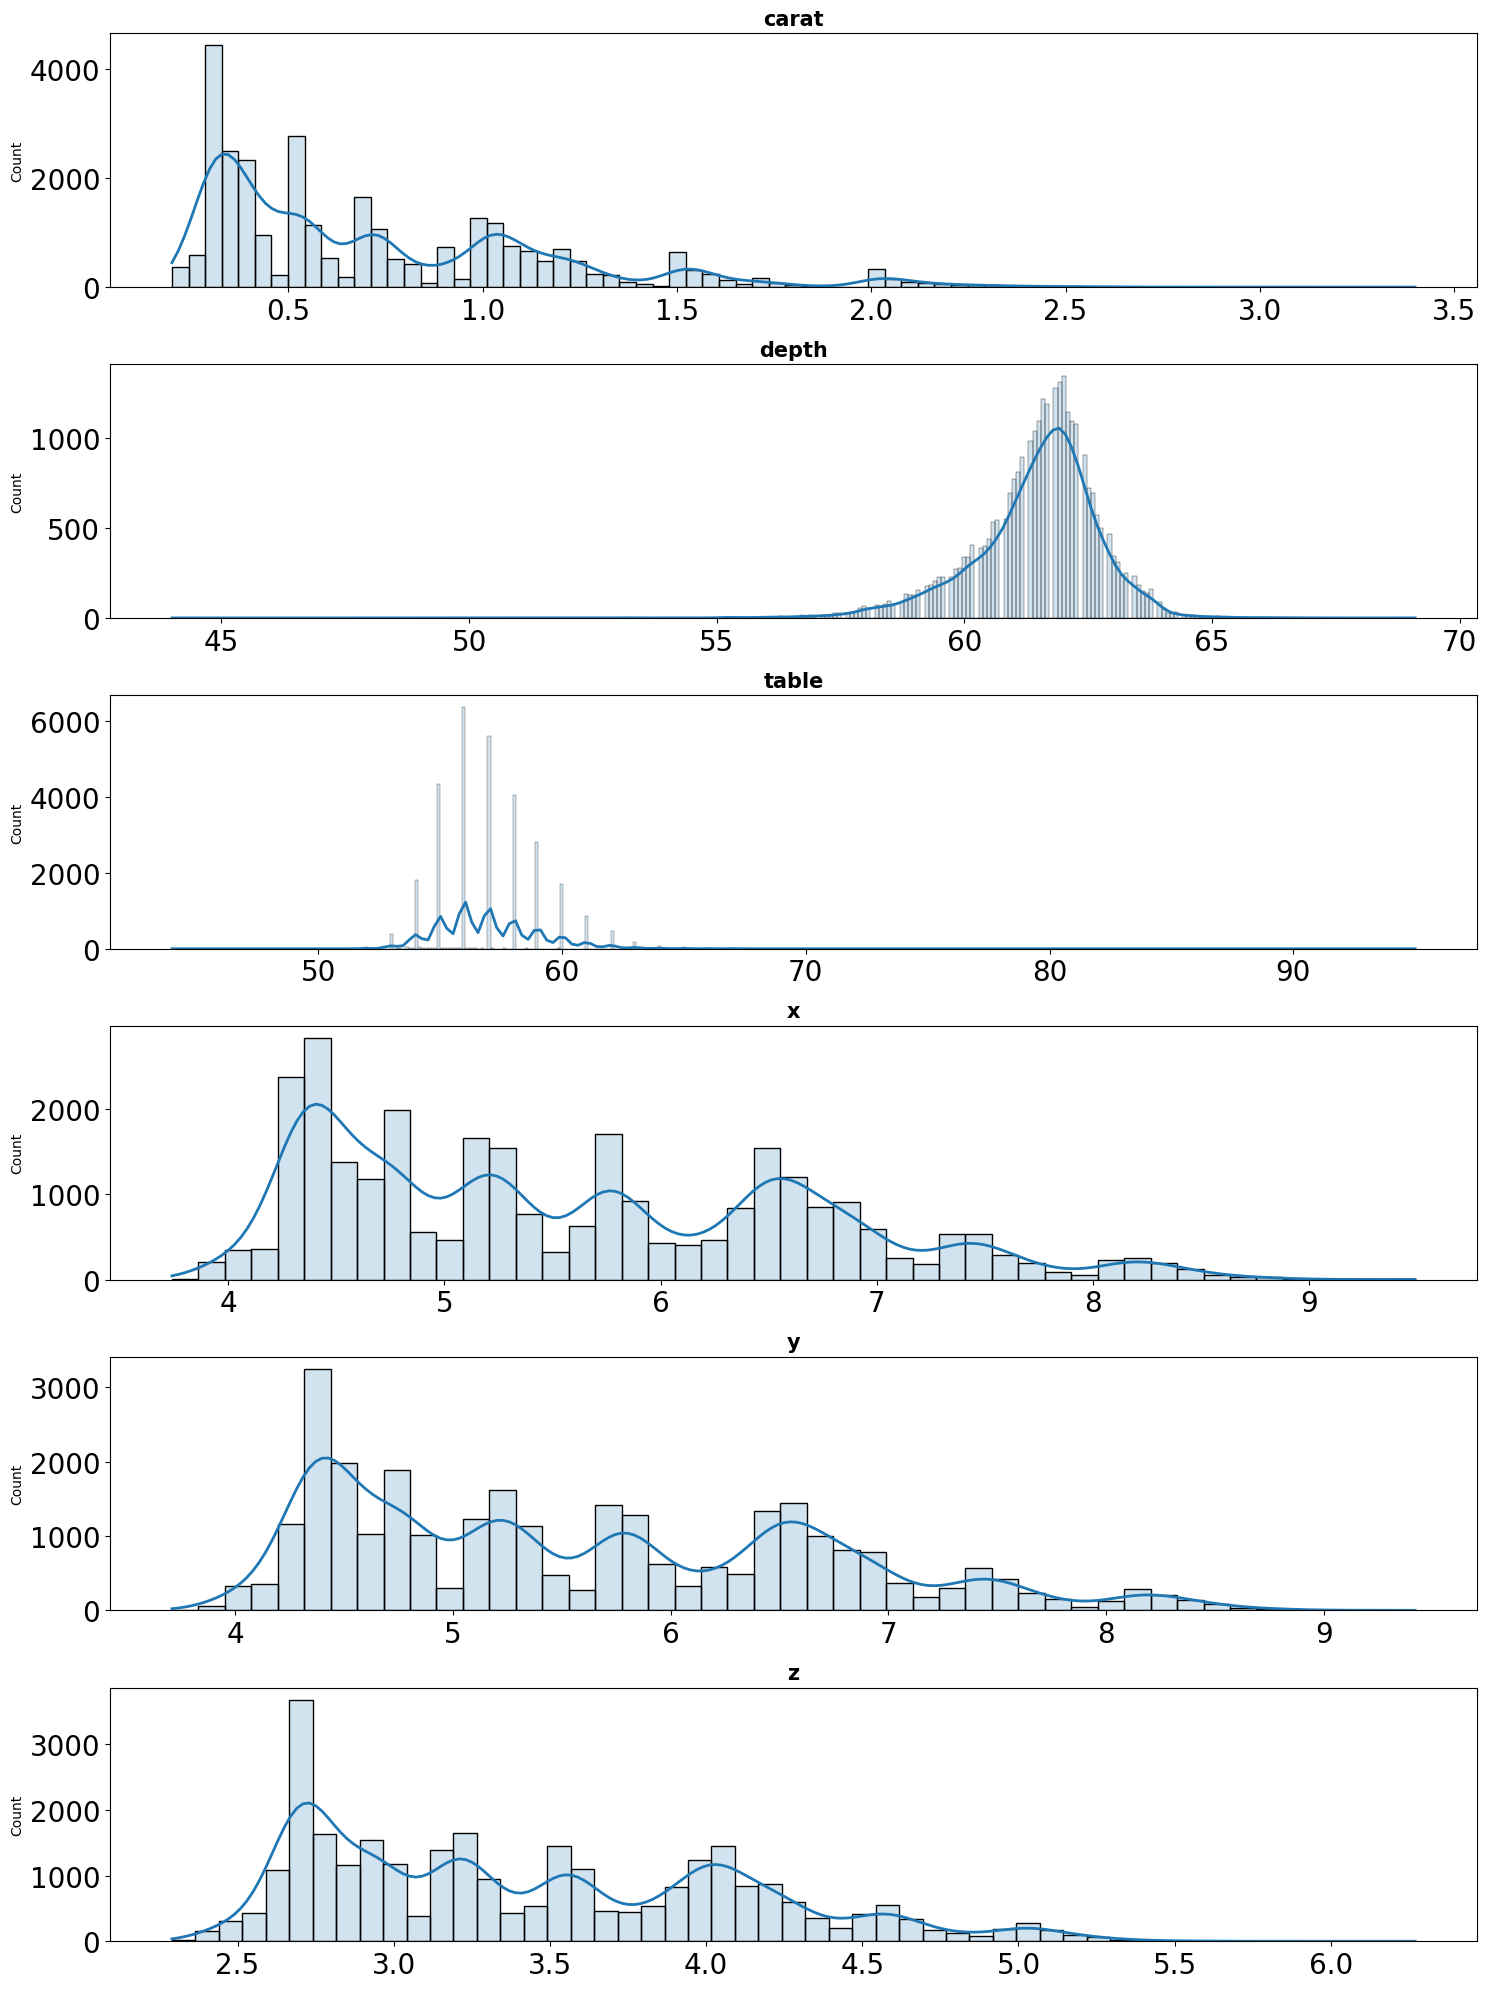

In [60]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 20))

axes = axes.flat

columnas_numeric = df_train.drop(['price'], axis=1).select_dtypes(include = np.number)

for i, colum in enumerate(columnas_numeric.columns): 
    sns.histplot(
        data=columnas_numeric,
        x=colum,
        kde=True, 
        line_kws={'linewidth': 2}, 
        alpha=0.2, 
        ax=axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = 'bold')
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel('')
    

fig.tight_layout();

#### Categoric:

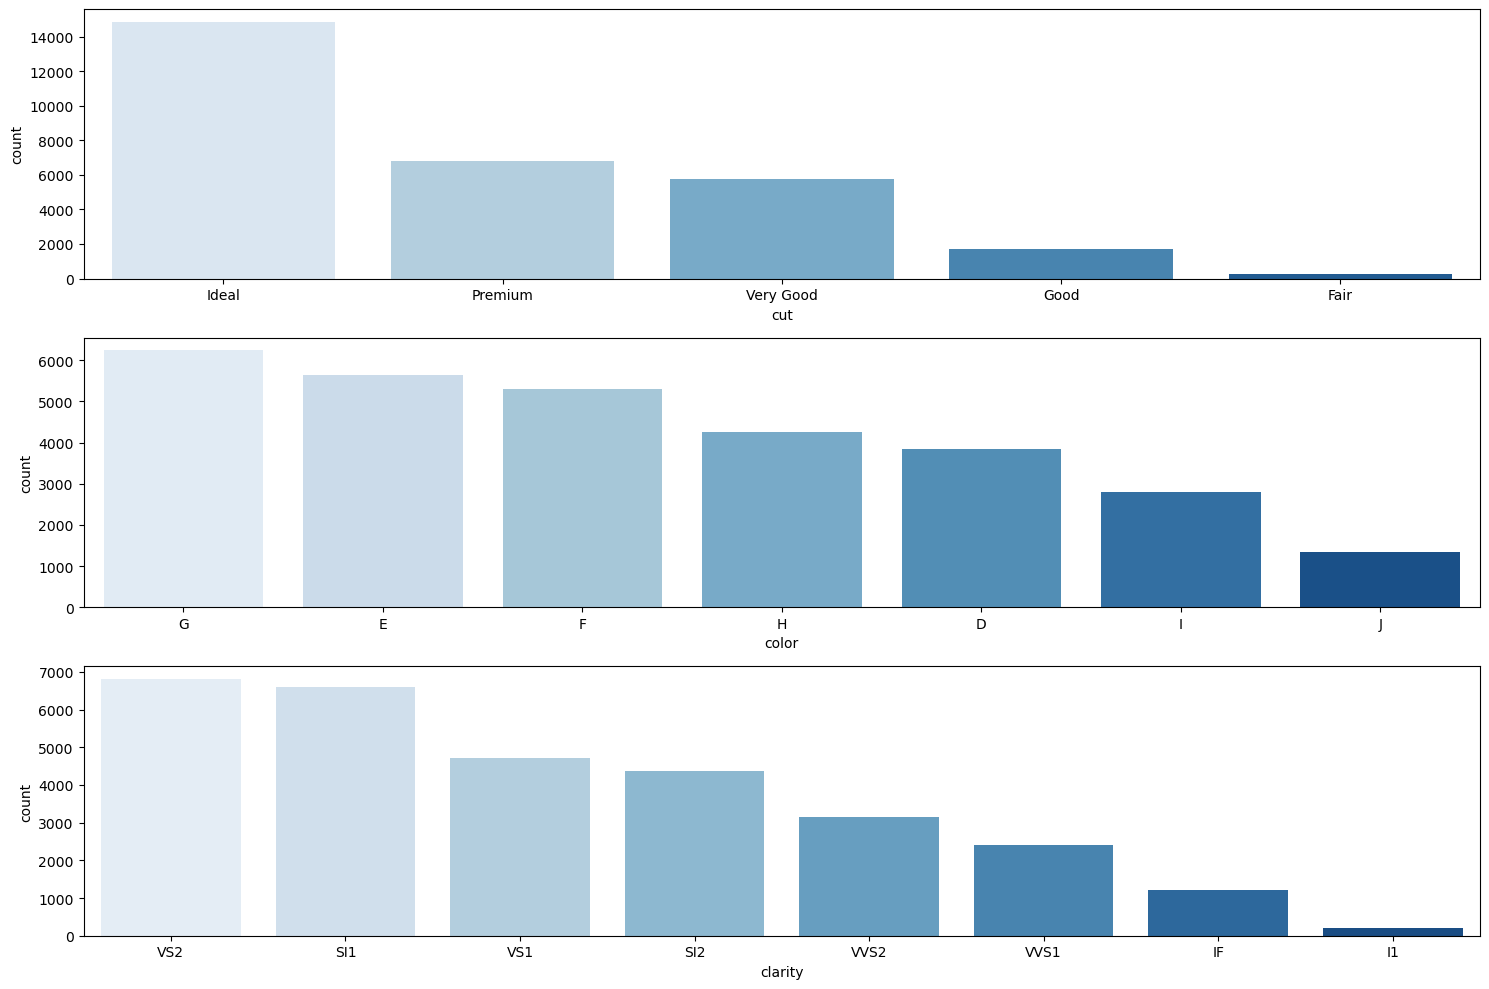

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))

axes = axes.flat

columnas_categoric = df_train.select_dtypes(include='object').columns

for i, col in enumerate(columnas_categoric):
    sns.countplot(
                x=df_train[col], 
                ax=axes[i],
                palette='Blues', 
                order=df_train[col].value_counts().index)

fig.tight_layout();

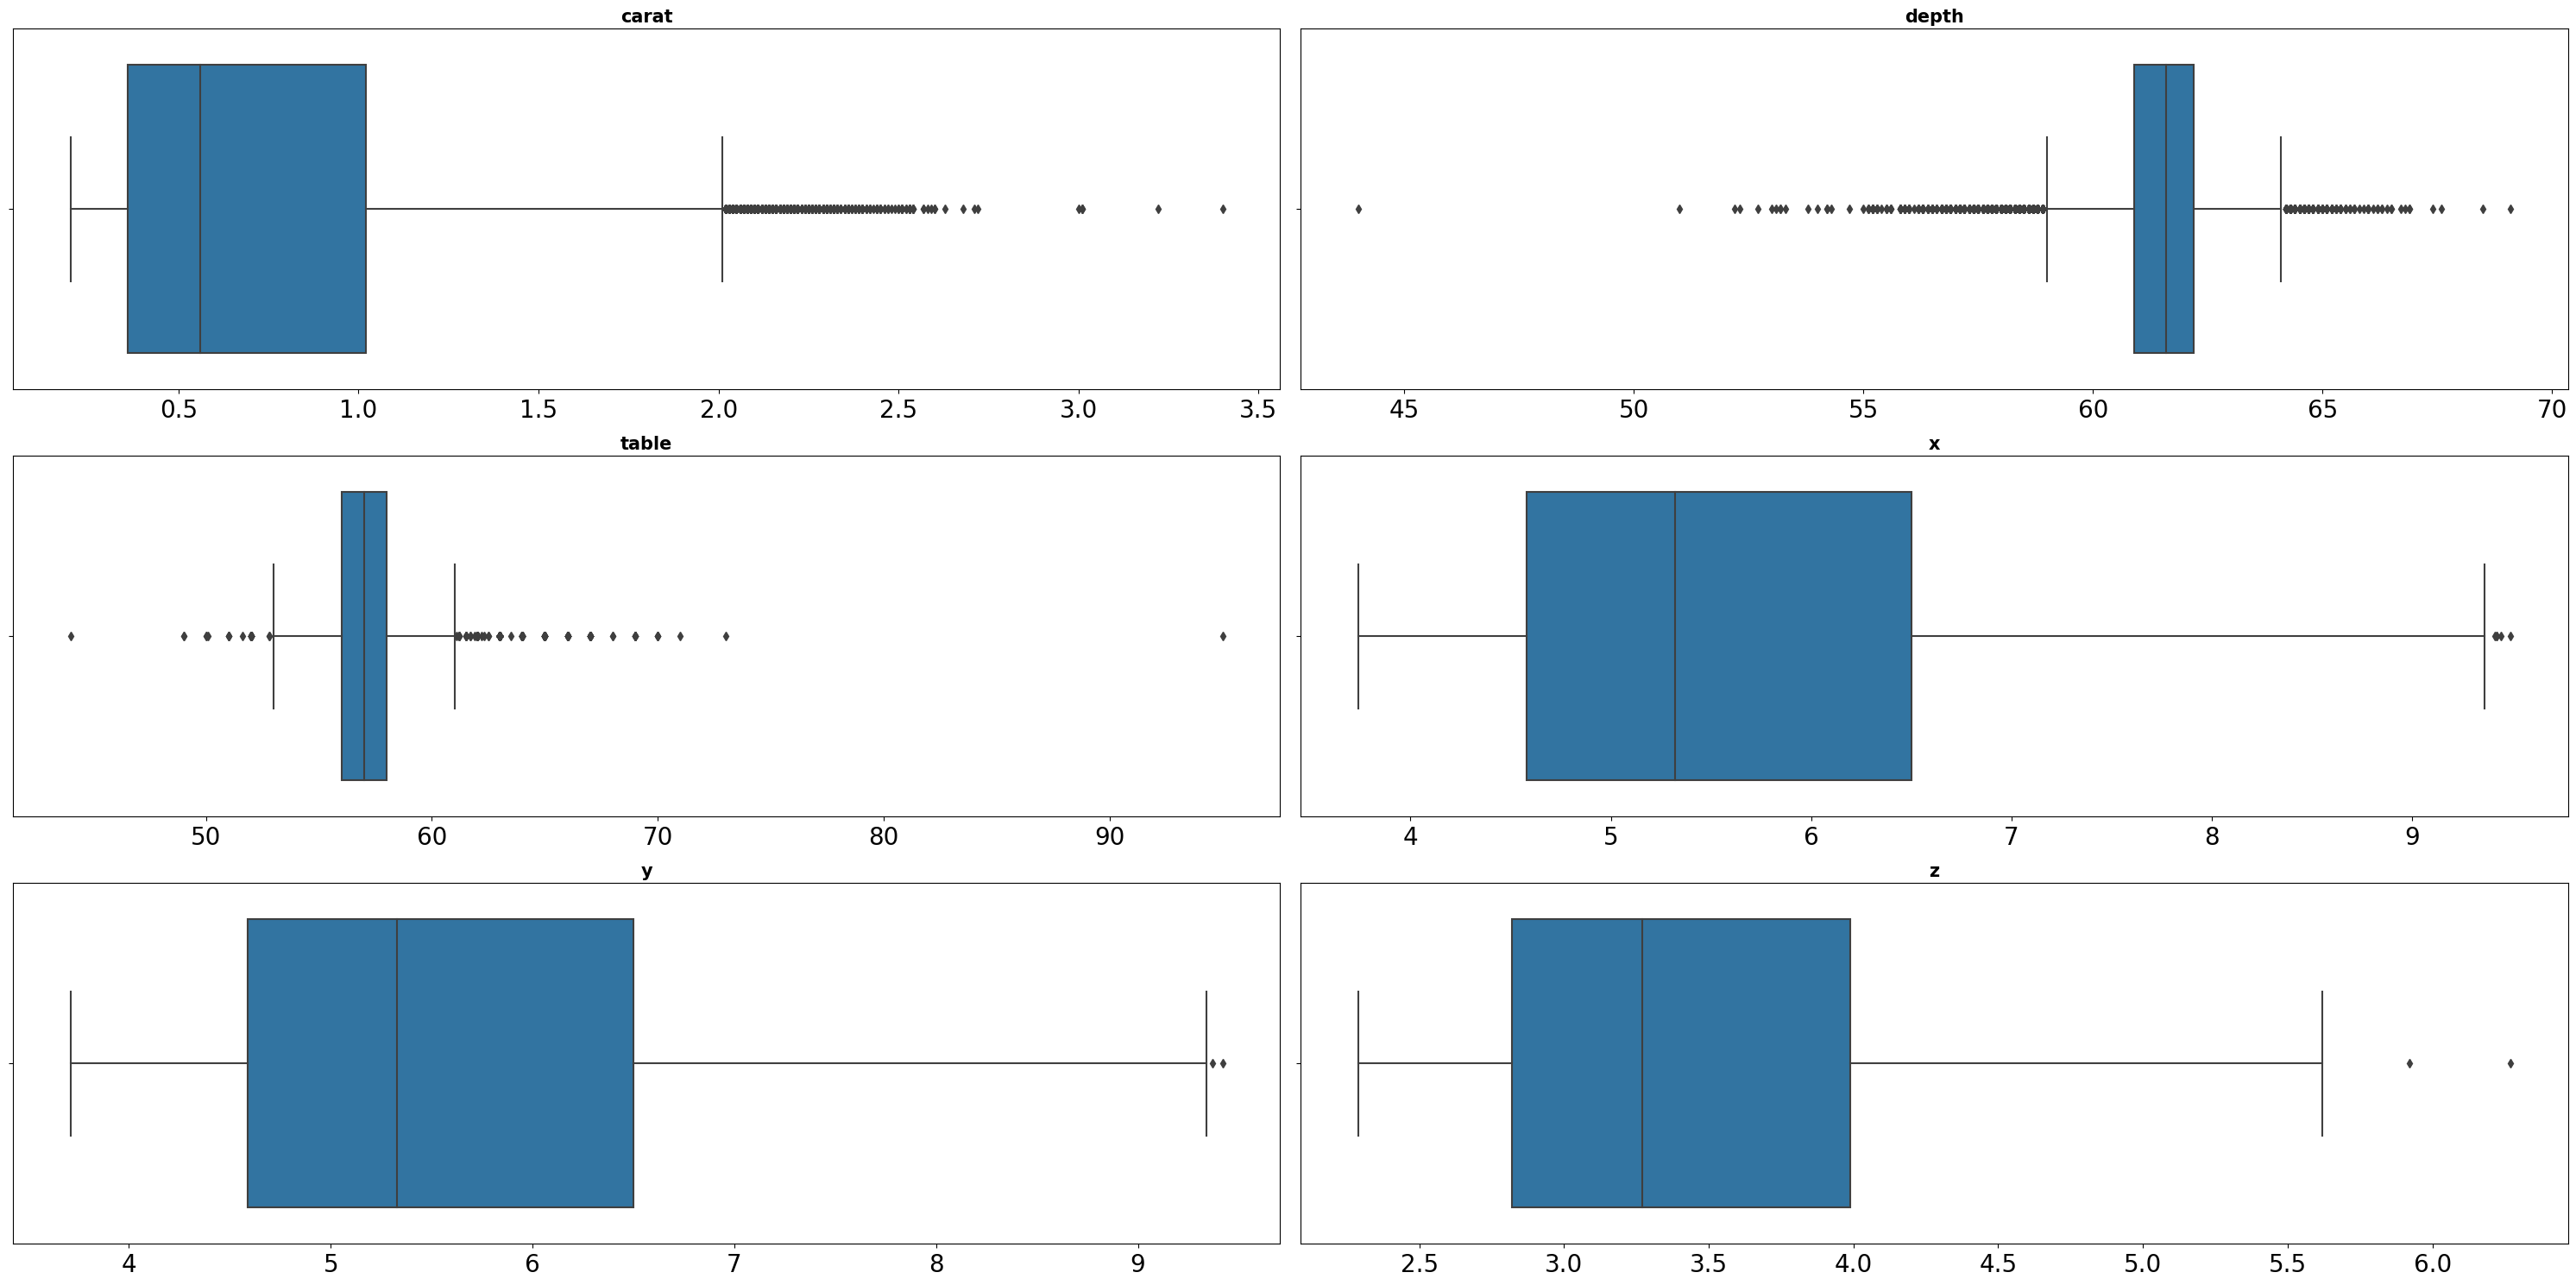

In [62]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 15))

axes = axes.flat

columnas_numeric = df_train.drop(['price'], axis=1).select_dtypes(include = np.number)

for i, colum in enumerate(columnas_numeric.columns): 
    sns.boxplot(
        data=df_train,
        x=colum,  
        ax=axes[i])
    
    axes[i].set_title(colum, fontsize=15, fontweight='bold')
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel('')
    

fig.tight_layout();

In [63]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df_train[col], 25)
        Q3 = np.nanpercentile(df_train[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = len(list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        
    return dicc_indices 

ind = detectar_outliers(columnas_numeric, df_train)
ind

{'carat': 713, 'depth': 1422, 'table': 909, 'x': 5, 'y': 2, 'z': 2}

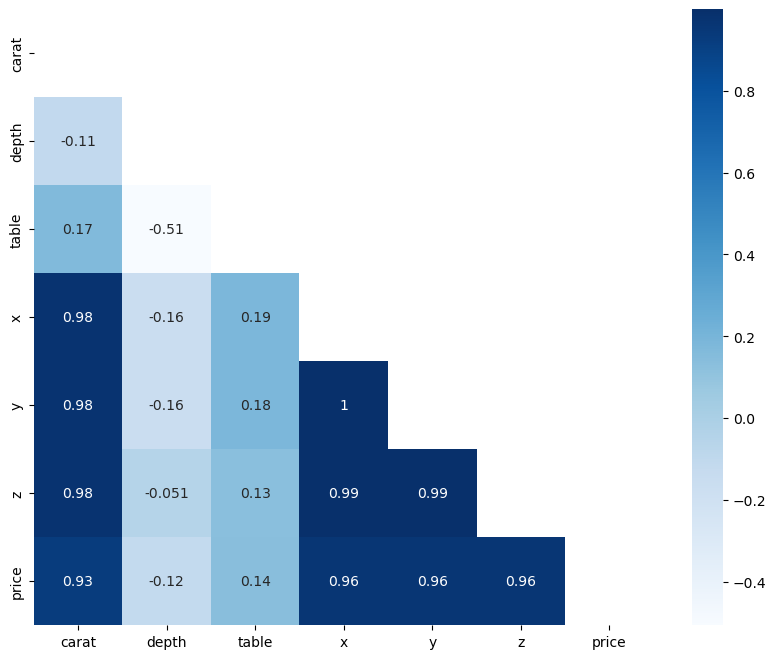

In [64]:
mask = np.triu(np.ones_like(df_train.corr(numeric_only=True), dtype=np.bool_))
sns.heatmap(df_train.corr(numeric_only=True), 
            cmap='Blues', 
            mask=mask,
            annot=True);

# estandarización

In [65]:
df_copy = df_train.copy()

In [66]:
def standardize_numeric_data(df):
    # Extraer columnas numéricas excluyendo variables discretas
    num_columns = df.select_dtypes(include=np.number).drop(['price'], axis=1).columns
    
    # Crear objeto RobustScaler y ajustarlo a las columnas numéricas
    robust = RobustScaler()
    robust.fit(df[num_columns])
    
    # Transforma las columnas numéricas y convierte el array resultante en un dataframe
    X_robust = robust.transform(df[num_columns])
    df[num_columns] = X_robust
    
    with open(f'../data/rob_scaler.pkl', 'wb') as rob_scal:
        pickle.dump(robust, rob_scal)  

    return df

In [67]:
num_columns = df_copy.select_dtypes(include=np.number).drop(['price'], axis=1).columns
num_columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [68]:
df_copy = standardize_numeric_data(df_copy)
df_copy.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,-0.393939,Premium,D,SI2,0.615385,0.5,-0.526042,-0.549738,-0.504274,6.353
1,0.681818,Ideal,E,VVS2,0.846154,-0.5,0.572917,0.591623,0.658120,9.183
3,0.787879,Very Good,G,SI2,1.230769,0.0,0.635417,0.612565,0.726496,8.371
5,-0.045455,Ideal,F,VS1,-0.153846,0.0,-0.072917,-0.068063,-0.068376,7.496
7,-0.348485,Ideal,E,VVS2,-1.230769,-0.5,-0.411458,-0.403141,-0.470085,6.877


# encoding

In [69]:
df_copy_2= df_train.copy()
df_copy_2.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
5,0.53,Ideal,F,VS1,61.4,57.0,5.18,5.20,3.19,7.496
7,0.33,Ideal,E,VVS2,60.0,56.0,4.53,4.56,2.72,6.877
